# K nearest neighbors

First some tricks: 

1. to create a toy datasets, we can shuffle a list

In [2]:
import random

data = [n for n in range(1000)]
data = data[:] # to create a shallow copy which is equivalent to data.copy() for lists. It's a new list.
random.shuffle(data)


In [3]:
data

[301,
 75,
 59,
 871,
 562,
 857,
 606,
 339,
 749,
 176,
 760,
 981,
 759,
 761,
 919,
 605,
 220,
 890,
 744,
 888,
 769,
 85,
 993,
 519,
 260,
 766,
 266,
 612,
 193,
 267,
 318,
 636,
 292,
 180,
 515,
 277,
 554,
 312,
 915,
 393,
 199,
 842,
 946,
 647,
 119,
 858,
 399,
 742,
 999,
 642,
 795,
 503,
 747,
 540,
 96,
 242,
 791,
 757,
 83,
 516,
 209,
 982,
 686,
 676,
 504,
 275,
 247,
 70,
 444,
 590,
 805,
 682,
 800,
 824,
 572,
 831,
 4,
 664,
 906,
 173,
 535,
 810,
 427,
 646,
 578,
 314,
 486,
 746,
 246,
 105,
 827,
 525,
 756,
 345,
 852,
 764,
 330,
 912,
 207,
 477,
 17,
 187,
 882,
 514,
 391,
 588,
 169,
 870,
 864,
 966,
 886,
 774,
 414,
 161,
 124,
 327,
 629,
 417,
 421,
 42,
 701,
 434,
 20,
 231,
 481,
 597,
 142,
 52,
 724,
 936,
 781,
 639,
 0,
 155,
 741,
 924,
 901,
 140,
 269,
 159,
 400,
 294,
 581,
 233,
 475,
 522,
 174,
 663,
 697,
 476,
 921,
 780,
 624,
 44,
 619,
 703,
 653,
 644,
 10,
 567,
 690,
 328,
 626,
 325,
 674,
 844,
 903,
 649,
 145,
 1

2. To find the most recurring element, we can use `counter` and `.most_common(1)[0]`

In [4]:
from typing import List
from collections import Counter 

labels = ['a', 'b', 'c', 'b']

votes = Counter(labels)
winner, _ = votes.most_common(1)[0]
winner

'b'

In the python course, it used this code to find the majority element. 

```python
numbers = [7, 8, 8, 8, 7, 7, 7]

for num in num_list:
    count = num_list.count(num)
    if count > len(num_list) // 2:
        num
```

## k-nearest neighbour 

This uses the Iris dataset.  

In [5]:
import requests
data = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

with open('iris.data', 'w') as f:
    f.write(data.text)

It got screwed up in the next step. Lots of good troubleshooting. But the problem was the dataset had some empty rows at the end.

In [6]:
import csv

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [row for row in reader]

iris_data

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa'],
 ['4.7', '3.2', '1.3', '0.2', 'Iris-setosa'],
 ['4.6', '3.1', '1.5', '0.2', 'Iris-setosa'],
 ['5.0', '3.6', '1.4', '0.2', 'Iris-setosa'],
 ['5.4', '3.9', '1.7', '0.4', 'Iris-setosa'],
 ['4.6', '3.4', '1.4', '0.3', 'Iris-setosa'],
 ['5.0', '3.4', '1.5', '0.2', 'Iris-setosa'],
 ['4.4', '2.9', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.1', '1.5', '0.1', 'Iris-setosa'],
 ['5.4', '3.7', '1.5', '0.2', 'Iris-setosa'],
 ['4.8', '3.4', '1.6', '0.2', 'Iris-setosa'],
 ['4.8', '3.0', '1.4', '0.1', 'Iris-setosa'],
 ['4.3', '3.0', '1.1', '0.1', 'Iris-setosa'],
 ['5.8', '4.0', '1.2', '0.2', 'Iris-setosa'],
 ['5.7', '4.4', '1.5', '0.4', 'Iris-setosa'],
 ['5.4', '3.9', '1.3', '0.4', 'Iris-setosa'],
 ['5.1', '3.5', '1.4', '0.3', 'Iris-setosa'],
 ['5.7', '3.8', '1.7', '0.3', 'Iris-setosa'],
 ['5.1', '3.8', '1.5', '0.3', 'Iris-setosa'],
 ['5.4', '3.4', '1.7', '0.2', 'Iris-setosa'],
 ['5.1', '3.7', '1.5', '0.4', 'Iri

This checks whether it's a list.

In [7]:
isinstance(iris_data[0], list)

True

In [8]:
isinstance([row for row in iris_data], list)
# every row is a list, but the last row was an empty list, so it doesn't notice that it had empty index spaces

True

In [9]:
iris_data[0][-1].split('-')[-1]

'setosa'

In [10]:
iris_data[0]

['5.1', '3.5', '1.4', '0.2', 'Iris-setosa']

In [13]:
from scratch.k_nearest_neighbors import LabeledPoint   # this uses the namedtuple from k_nearest_neighbors.py
import csv


def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

In [ ]:
iris_data

[LabeledPoint(point=[5.1, 3.5, 1.4, 0.2], label='setosa'),
 LabeledPoint(point=[4.9, 3.0, 1.4, 0.2], label='setosa'),
 LabeledPoint(point=[4.7, 3.2, 1.3, 0.2], label='setosa'),
 LabeledPoint(point=[4.6, 3.1, 1.5, 0.2], label='setosa'),
 LabeledPoint(point=[5.0, 3.6, 1.4, 0.2], label='setosa'),
 LabeledPoint(point=[5.4, 3.9, 1.7, 0.4], label='setosa'),
 LabeledPoint(point=[4.6, 3.4, 1.4, 0.3], label='setosa'),
 LabeledPoint(point=[5.0, 3.4, 1.5, 0.2], label='setosa'),
 LabeledPoint(point=[4.4, 2.9, 1.4, 0.2], label='setosa'),
 LabeledPoint(point=[4.9, 3.1, 1.5, 0.1], label='setosa'),
 LabeledPoint(point=[5.4, 3.7, 1.5, 0.2], label='setosa'),
 LabeledPoint(point=[4.8, 3.4, 1.6, 0.2], label='setosa'),
 LabeledPoint(point=[4.8, 3.0, 1.4, 0.1], label='setosa'),
 LabeledPoint(point=[4.3, 3.0, 1.1, 0.1], label='setosa'),
 LabeledPoint(point=[5.8, 4.0, 1.2, 0.2], label='setosa'),
 LabeledPoint(point=[5.7, 4.4, 1.5, 0.4], label='setosa'),
 LabeledPoint(point=[5.4, 3.9, 1.3, 0.4], label='setosa'

In [14]:
from typing import Dict
from collections import defaultdict
from scratch.linear_algebra import Vector, distance

# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

## This is next level. Study this. 

Firstly to the pairs, with their double for loops. Then the triple for-loop to plot the points. 

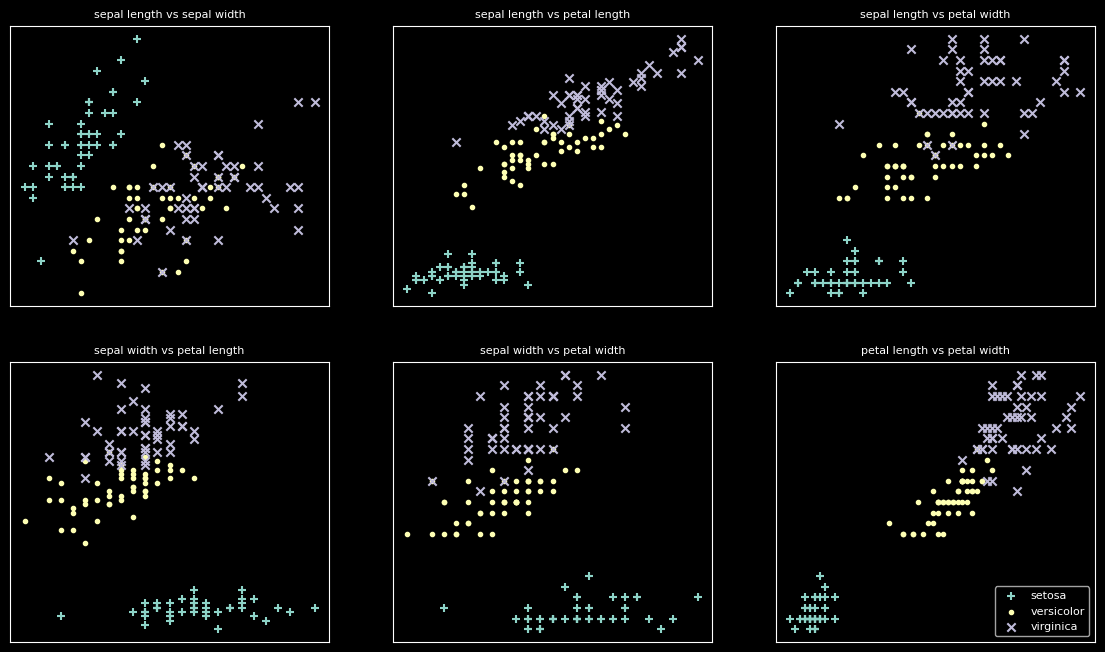

In [15]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (14, 8)            # to change the default size of the plot

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']                              # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):                                # for the rows of subplots
    for col in range(3):                            # for the columns
        i, j = pairs[3 * row + col]                 # 3 * row + col is the index of the subplot
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 8})
plt.show()

## Split the data in train and test sets. 


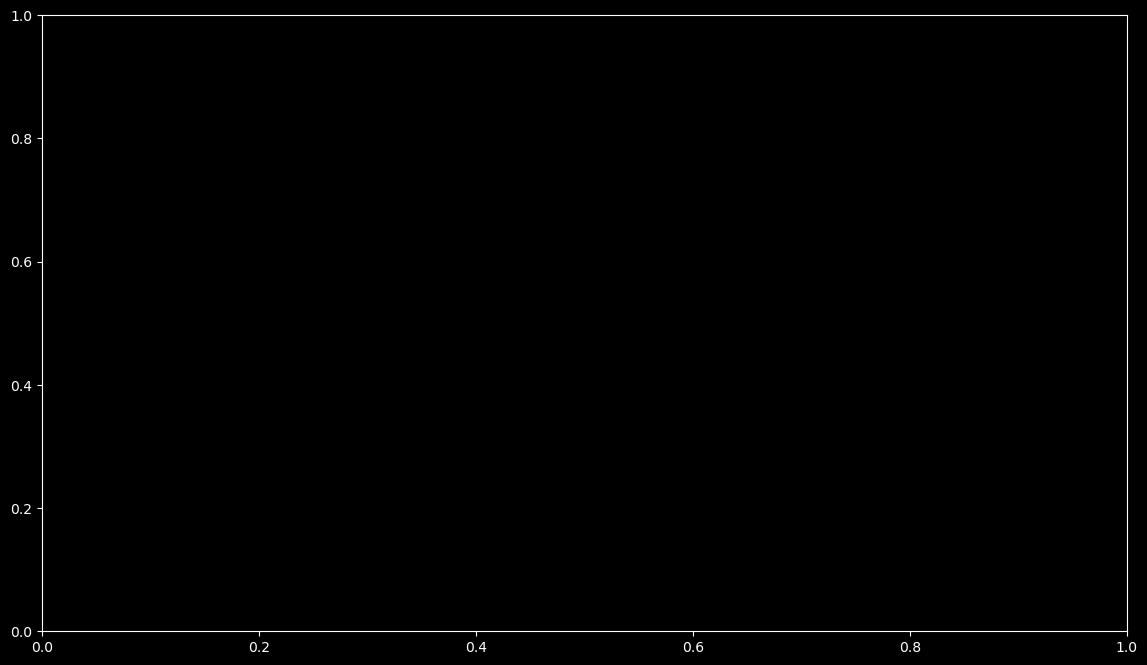

In [16]:
plt.savefig('im/iris_scatter.png')
plt.gca().clear()

import random
from scratch.machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [19]:
from typing import Tuple

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

from scratch.k_nearest_neighbors import majority_vote

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)

print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


^^ interesting how close it got to predicting all the data based on distance measurements from its neighbours. 

- note how it's got 97.7% correct. 
- also note how the confusion matrix is constructed as a defaultdict with as key the two labels and as the value the number of times they occur. 


For the scikit-learn application, including the below example, see [here](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)

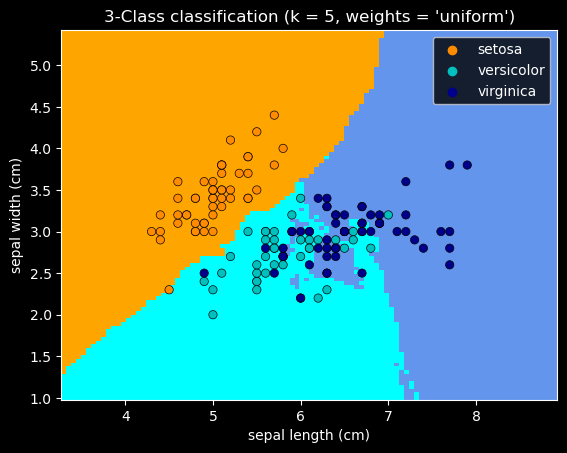

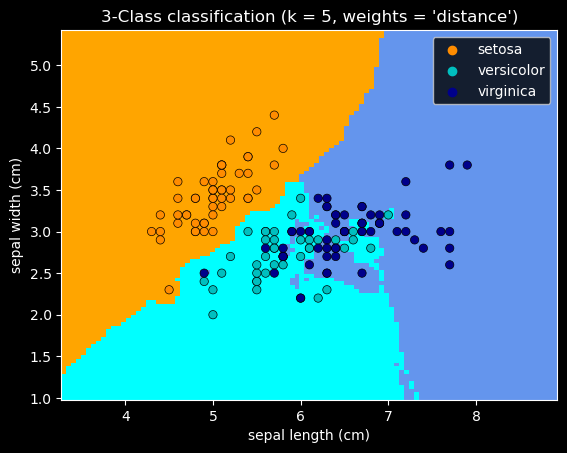

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 5

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)  # note this notation with a %. 
    )

plt.show()

Next is a quick attempt at the scikit-learn version of confusion matrix:

In [6]:
# imagine we have a list of the actual values and a list of the predicted values
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test, prediction)  # test and prediction are lists of the actual and predicted values, which the above doesn't have

cm_display = ConfusionMatrixDisplay(cm).plot()

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

## about **the curse of dimensionality** with K-nearest neighbors

In [4]:
import random
import tqdm

dimensions = range(1, 101)

avg_distances = []
min_distances = []

from scratch.k_nearest_neighbors import random_distances

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

min_avg_ratio = [min_dist / avg_dist
                    for min_dist, avg_dist in zip(min_distances, avg_distances)]

Curse of Dimensionality: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Next I would like to plot the curves like in the book. 

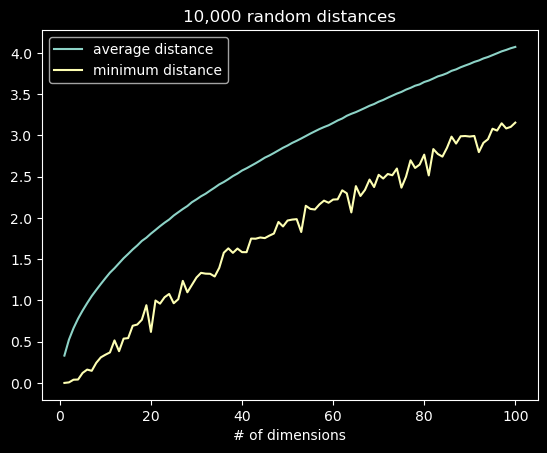

In [6]:
import matplotlib.pyplot as plt

plt.plot(dimensions, avg_distances)
plt.plot(dimensions, min_distances)
plt.legend(["average distance", "minimum distance"])
plt.xlabel("# of dimensions")
plt.title("10,000 random distances")
plt.show()

Text(0.5, 0, '# of dimensions')

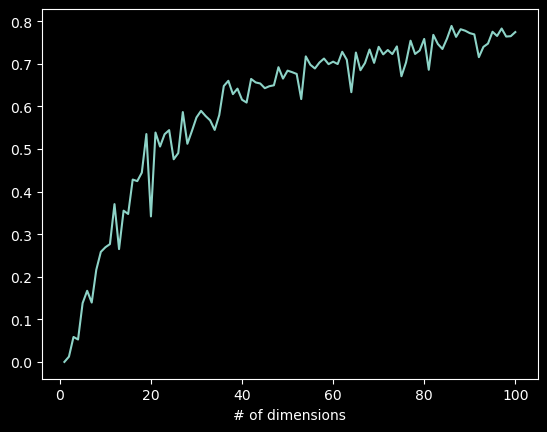

In [8]:
plt.plot(dimensions, min_avg_ratio) 
plt.xlabel("# of dimensions")

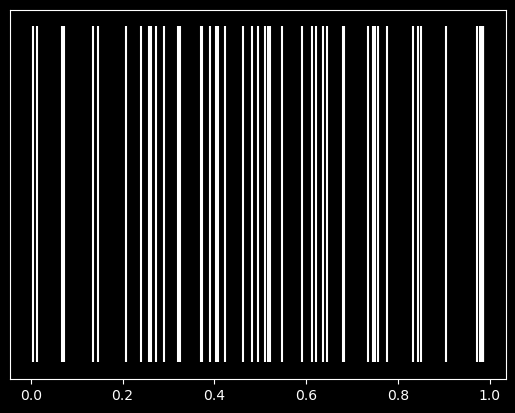

In [19]:
x = [random.random() for _ in range(50)]

plt.vlines(x,ymin=0, ymax=1)   # I first used a scatter with y=0 50 times

plt.gca().get_yaxis().set_visible(False)

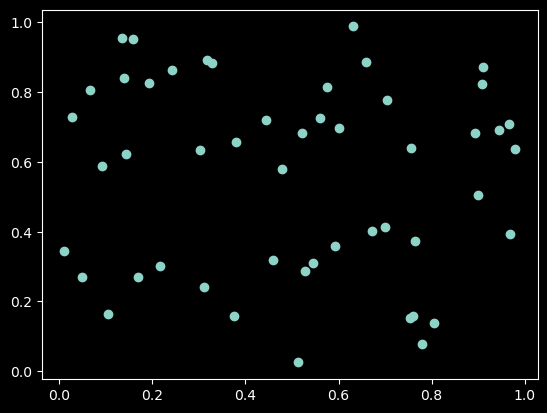

In [20]:
x = [random.random() for _ in range(50)]
y = [random.random() for _ in range(50)]

plt.scatter(x, y)

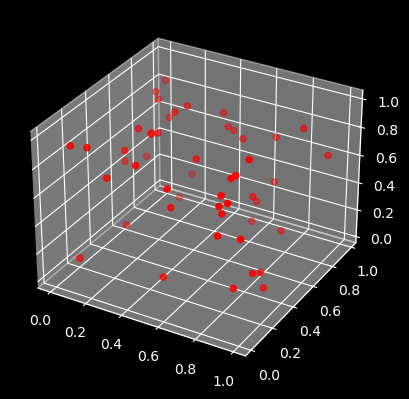

In [27]:
x = [random.random() for _ in range(50)]
y = [random.random() for _ in range(50)]
z = [random.random() for _ in range(50)]

# fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")     # to create the 3D plot
ax.scatter3D(x, y, z, color='red') # 3D scatter plot